In [19]:
import jax
import jax.numpy as jnp
from jax import random

import numpy as np

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, log_likelihood

import matplotlib.pyplot as plt

from model import *

plt.rcParams['font.size'] = 14
# plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['axes.grid']=False
plt.rcParams['grid.linestyle']='--'
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['axes.axisbelow'] = True

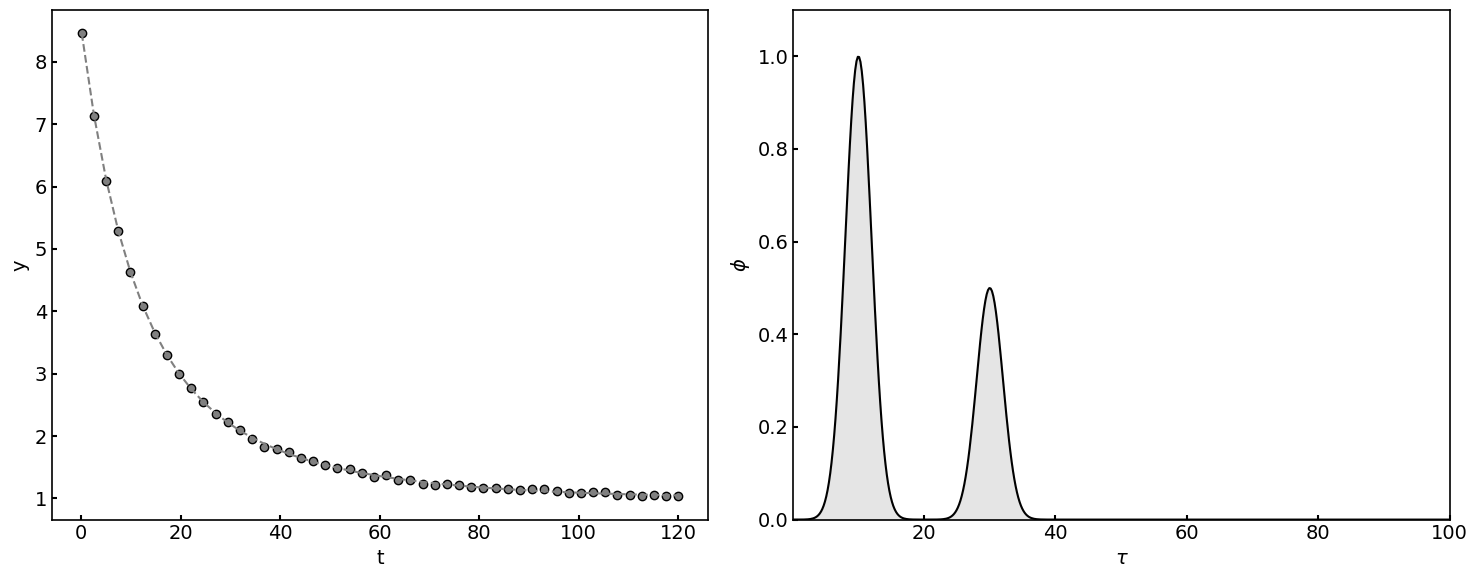

In [20]:

# 離散化されたτ空間（例: 対数スケールで10^-1 ～ 10^2）
N = 500
# tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)
tau = jnp.linspace(0.1, 100.0, N)  # τ: (N,)

# 入力時間軸
M = 50
t = jnp.linspace(0.1, 120.0, M)  # t: (M,)

b=1
h_true=jnp.array([1.0, 0.5])
mu_true=jnp.array([10.0, 30.0])
sigma_true=jnp.array([2.0, 2.0])
phi_true = calc_phi_K(tau, h_true, mu_true, sigma_true)
y_true = calc_f_K(t, tau, b, h_true, mu_true, sigma_true)

key = random.PRNGKey(0)
sigma_y_true = 0.02
noise = sigma_y_true * random.normal(key, shape=y_true.shape)
y_obs = y_true + noise

plt.figure(figsize=(15, 6))

plt.subplot(121)
plt.plot(t, y_true, ls='--', color='gray')
plt.scatter(t, y_obs, color='gray', edgecolor='k')
plt.xlabel(r't')
plt.ylabel(r'y')

plt.subplot(122)
plt.plot(tau, phi_true, c='k')
plt.fill_between(tau, phi_true, color='gray', alpha=0.2)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')
plt.xlim(tau.min(), tau.max())
plt.ylim(0, 1.1)

plt.tight_layout()
plt.show()

In [26]:
num_samples = num_warmup = 1000
num_chains = 5
K = 2

kernel = NUTS(model, target_accept_prob=0.95)
mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
mcmc.run(random.PRNGKey(1), t=t, y_obs=y_obs, tau=tau, K=K)
mcmc.print_summary()

/var/folders/h6/361ss89923jd1mqx4n307p4w0000gn/T/ipykernel_36075/1057962457.py:6: UserWarning: There are not enough devices to run parallel chains: expected 5 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(5)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_samples=num_samples, num_warmup=num_warmup, num_chains=num_chains)
sample: 100%|██████████| 2000/2000 [00:10<00:00, 187.01it/s, 943 steps of size 1.82e-03. acc. prob=0.97] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         b      0.97      0.04      0.98      0.92      1.02    163.90      1.03
      h[0]      0.96      0.31      0.94      0.59      1.50    320.25      1.03
      h[1]      0.93      0.30      0.87      0.60      1.50    313.55      1.03
     mu[0]     27.10     15.95     30.07      9.09     44.54      3.55      1.90
     mu[1]     21.13     13.52     12.00      8.96     39.65      2.90      2.87
  sigma[0]      1.64      1.15      1.23      0.27      3.53      4.18      1.67
  sigma[1]      2.06      1.32      1.78      0.33      3.92      5.62      1.39
   sigma_y      0.02      0.00      0.02      0.01      0.02   1229.26      1.00

Number of divergences: 5


In [62]:
sorted_index = np.argsort( mcmc.get_samples()['mu'] )
samples = mcmc.get_samples()

In [65]:
sorted_samples = {}
keys = ['h', 'mu', 'sigma']
for key in keys:
    samples_k = []
    for i, j in enumerate(sorted_index):
        samples_k.append( samples[key][i, j] )
    samples_k = np.array( samples_k )
    sorted_samples[key] = samples_k

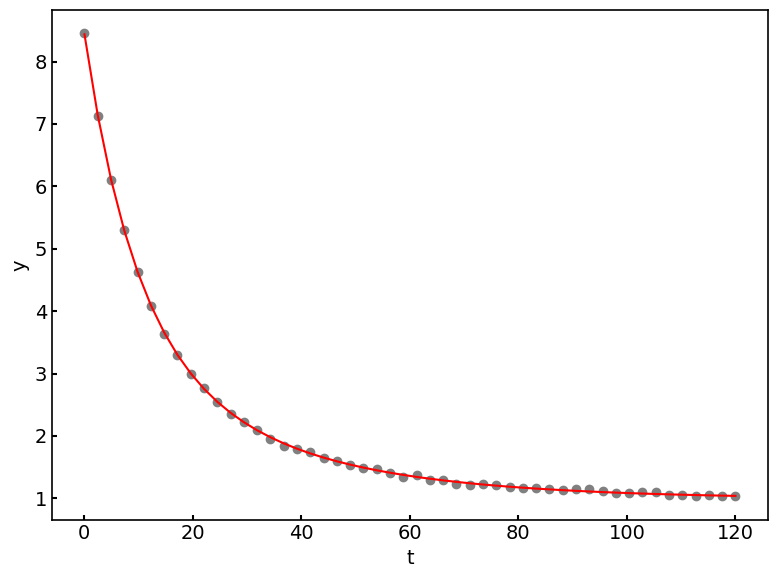

In [66]:
plt.figure(figsize=(8, 6))
plt.scatter(t, y_obs, c='gray')
plt.plot(t, mcmc.get_samples()['f'][-1, :], color='r')
plt.xlabel('t');plt.ylabel('y')
plt.tight_layout()
plt.show()

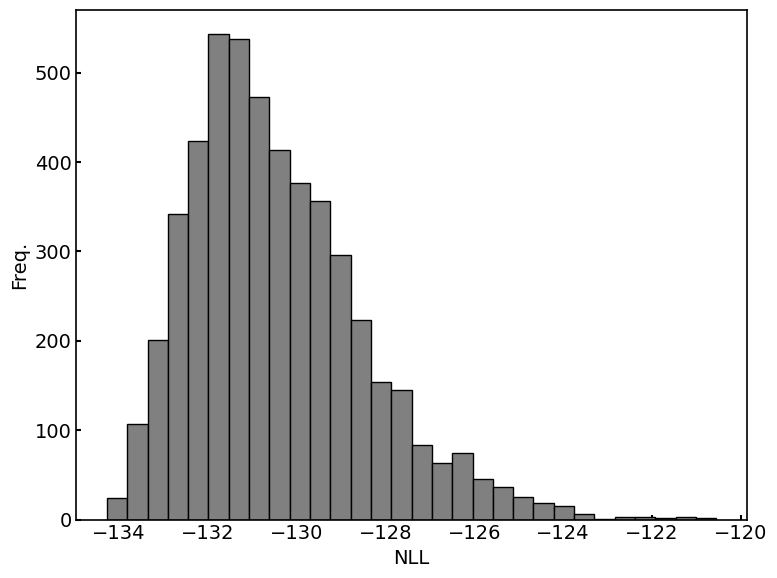

In [67]:
log_likelihood_dict = log_likelihood(
    model=model, posterior_samples=mcmc.get_samples(), 
    t=t, y_obs=y_obs, tau=tau, K=K)
nll = -1.0 * jnp.sum( log_likelihood_dict['obs'], axis=1)
plt.figure(figsize=(8, 6))
plt.hist(nll, bins=30, color='gray', edgecolor='k')
plt.xlabel('NLL'); plt.ylabel('Freq.')
plt.tight_layout()
plt.show()

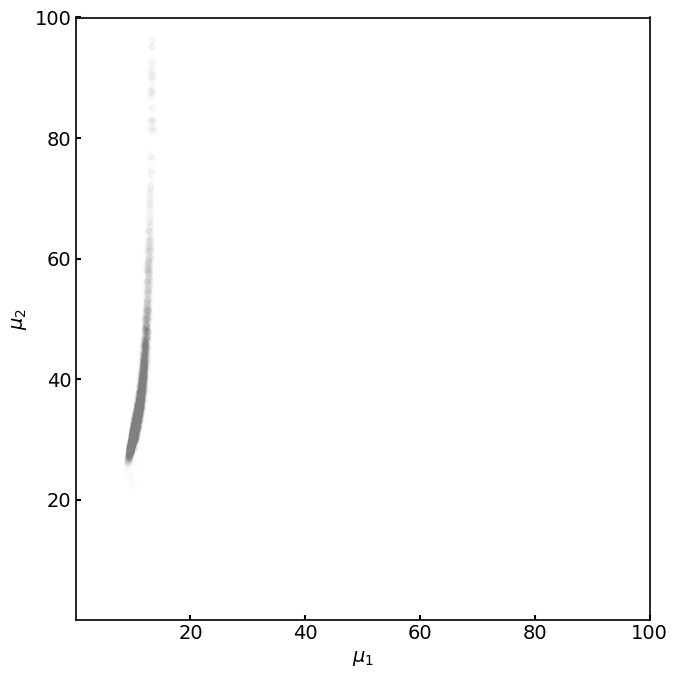

In [68]:
plt.figure(figsize=(7, 7))
plt.scatter(sorted_samples['mu'][:, 0], sorted_samples['mu'][:, 1], 
                    alpha=0.01, c='gray', s=20)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')
plt.xlim(tau.min(), tau.max())
plt.ylim(tau.min(), tau.max())
plt.tight_layout()
plt.show()

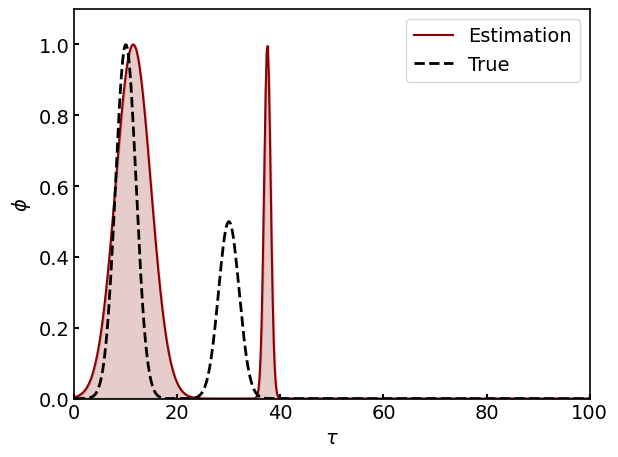

In [69]:
argmin_nll = np.argmin(nll)

tcd = np.zeros( len(tau) )
for k in range(K):
    est_sigma = np.mean( samples['sigma'][argmin_nll, k] )
    est_mean = np.mean( samples['mu'][argmin_nll, k] )
    tcd += gaussian(tau, est_mean, est_sigma)
    
plt.plot(tau, tcd, color='darkred', label='Estimation')
plt.fill_between(tau, tcd, color='darkred', alpha=0.2, lw=2)
    
plt.plot(tau, phi_true, c='k', ls='--', label='True', lw=2)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.legend()
plt.xlim(0, 100)
plt.ylim(0, 1.1)
plt.xlabel(r'$\tau$')
plt.ylabel(r'$\phi$')

plt.tight_layout()
plt.show()

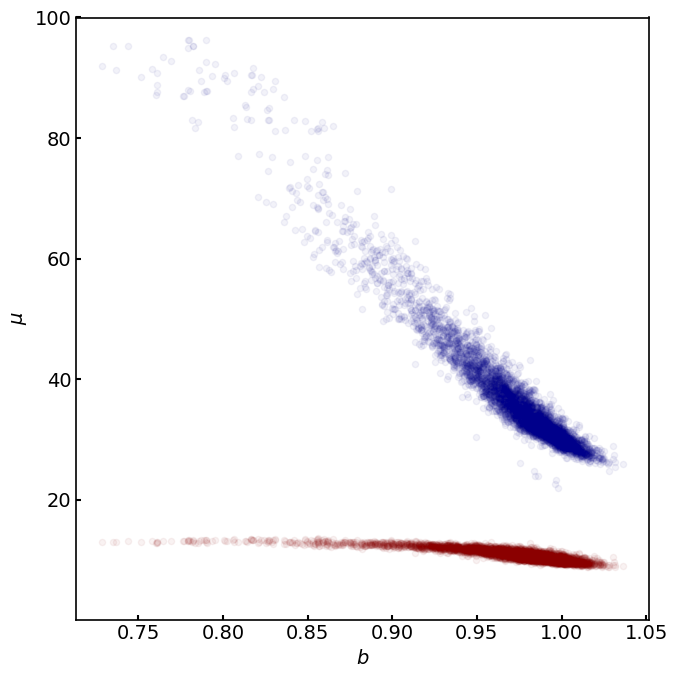

In [86]:
plt.figure(figsize=(7, 7))
plt.scatter(samples['b'], sorted_samples['mu'][:, 0], 
                    alpha=0.05, c='darkred', s=20)
plt.scatter(samples['b'], sorted_samples['mu'][:, 1], 
                    alpha=0.05, c='darkblue', s=20)
plt.xlabel(r'$b$')
plt.ylabel(r'$\mu$')
# plt.xlim(tau.min(), tau.max())
plt.ylim(tau.min(), tau.max())
plt.tight_layout()
plt.show()